In [60]:
import tensorflow as tf
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Load Data

In [83]:
import pandas as pd
df  = pd.read_csv("Z:/Divya/TEMP_transfers/toAni/BPN_P9LT_P9RT_flyCoords.csv")

In [84]:
def remove_stepcycle_predictions(df, joint_angles, velocity):

    if joint_angles == True:
        terms = ['D_flex', 'ball', '_r', 'cycle','tnum','fnum','flynum', 'SF', 'pos', '_x', '_y', '_z', 'rot', 'abduct']
    if velocity == True:
        terms = ['D_flex', 'ball', '_r', 'cycle', 'genotype', 'SF', 'pos', '_x', '_y', '_z']
    
    for i in terms:
        cols = [c for c in df.columns if c.endswith(i)]

        df = df.drop(columns=cols)

    return df

In [85]:
def filter_frames(df, f_0=400, f_f=1000, f_trl=1400):

    df = df.copy()

    df_filt = df.loc[
        ((df.loc[:, "fnum"] % f_trl) >= f_0) & ((df.loc[:, "fnum"] % f_trl) < f_f)
    ]

    return df_filt

In [86]:
def z_scoring(df):
    from scipy import stats

    for column in df.columns.to_list():
        if column not in ['x_vel', 'y_vel', 'z_vel']:
            df[column] = stats.zscore(df[column])

    return df


# Preprocess

In [87]:
#df = filter_frames(df)
df = df.reset_index()
df  = remove_stepcycle_predictions(df, joint_angles=True, velocity=False)
df = df[df['genotype']=='P9RT']
df  = df.drop(columns=['index','genotype'])
df = z_scoring(df)
df

,L1A_flex,L1B_flex,L1C_flex,L2A_flex,L2B_flex,L2C_flex,L3A_flex,L3B_flex,L3C_flex,R1A_flex,...,R1C_flex,R2A_flex,R2B_flex,R2C_flex,R3A_flex,R3B_flex,R3C_flex,x_vel,y_vel,z_vel
305200,0.758239,0.269748,0.714661,-0.539818,-0.733766,-1.731932,0.056881,0.282390,-0.310062,-0.264968,...,0.693084,-0.585737,-1.094131,-1.513160,1.320046,-0.004703,0.497005,1.096183,2.616862,5.257112
305201,0.831051,0.261139,0.636890,-0.576519,-0.610017,-1.720330,0.174117,0.172505,-0.249874,-0.271291,...,0.694916,-0.579001,-1.113678,-1.506804,0.212285,-0.272115,0.589078,1.186000,2.676443,5.157295
305202,0.824661,0.225952,0.555822,-0.619366,-0.503481,-1.727147,0.177643,0.132534,-0.203036,-0.267053,...,0.664057,-0.530863,-1.159401,-1.499572,-0.320635,-0.432969,0.692877,1.273659,2.689129,5.039348
305203,0.768999,0.160785,0.460894,-0.693495,-0.411975,-1.742215,0.167572,0.133926,-0.180630,-0.235028,...,0.604496,-0.430864,-1.228570,-1.493661,-0.468435,-0.493286,0.799473,1.358636,2.643880,4.900506
305204,0.701472,0.088044,0.365363,-0.797573,-0.335046,-1.749145,0.162281,0.143477,-0.183611,-0.192129,...,0.541270,-0.281702,-1.303932,-1.493818,-0.461853,-0.511329,0.897564,1.440223,2.531357,4.738617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487195,-0.308088,-0.902133,-0.788416,-0.455089,-0.965098,-0.731755,1.814973,-0.622985,-0.564088,1.669204,...,0.589357,-1.684049,0.313072,0.856602,-0.335242,2.837208,2.588538,-0.428126,0.975551,0.811247
487196,-0.303594,-0.903629,-0.788044,-0.471002,-0.972361,-0.740052,1.767146,-0.655100,-0.613778,1.632109,...,0.533910,-1.358959,0.320817,0.854324,-0.325824,2.827270,2.594308,-0.656853,1.225061,0.704523
487197,-0.297195,-0.909914,-0.786307,-0.484294,-0.982479,-0.748602,1.729157,-0.692736,-0.674416,1.598554,...,0.495282,-0.973195,0.329923,0.847678,-0.320627,2.818182,2.595073,-0.860701,1.480759,0.588388
487198,-0.290678,-0.922501,-0.782228,-0.496396,-0.994606,-0.753511,1.710593,-0.723309,-0.729794,1.569301,...,0.466783,-0.970619,0.335979,0.857931,-0.321187,2.814204,2.593385,-1.038202,1.732315,0.469502


In [88]:
import numpy as np
import pandas as pd

def create_lagged_features(data, features, lag):
    df = data.copy()
    for feature in features:
        df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
        df = df.drop(columns=[f'{feature}'])
    df.dropna(inplace=True)  
    return df


In [89]:
features = ['x_vel','y_vel','z_vel']
#df = create_lagged_features(df, features, 2)
df

,L1A_flex,L1B_flex,L1C_flex,L2A_flex,L2B_flex,L2C_flex,L3A_flex,L3B_flex,L3C_flex,R1A_flex,...,R1C_flex,R2A_flex,R2B_flex,R2C_flex,R3A_flex,R3B_flex,R3C_flex,x_vel,y_vel,z_vel
305200,0.758239,0.269748,0.714661,-0.539818,-0.733766,-1.731932,0.056881,0.282390,-0.310062,-0.264968,...,0.693084,-0.585737,-1.094131,-1.513160,1.320046,-0.004703,0.497005,1.096183,2.616862,5.257112
305201,0.831051,0.261139,0.636890,-0.576519,-0.610017,-1.720330,0.174117,0.172505,-0.249874,-0.271291,...,0.694916,-0.579001,-1.113678,-1.506804,0.212285,-0.272115,0.589078,1.186000,2.676443,5.157295
305202,0.824661,0.225952,0.555822,-0.619366,-0.503481,-1.727147,0.177643,0.132534,-0.203036,-0.267053,...,0.664057,-0.530863,-1.159401,-1.499572,-0.320635,-0.432969,0.692877,1.273659,2.689129,5.039348
305203,0.768999,0.160785,0.460894,-0.693495,-0.411975,-1.742215,0.167572,0.133926,-0.180630,-0.235028,...,0.604496,-0.430864,-1.228570,-1.493661,-0.468435,-0.493286,0.799473,1.358636,2.643880,4.900506
305204,0.701472,0.088044,0.365363,-0.797573,-0.335046,-1.749145,0.162281,0.143477,-0.183611,-0.192129,...,0.541270,-0.281702,-1.303932,-1.493818,-0.461853,-0.511329,0.897564,1.440223,2.531357,4.738617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487195,-0.308088,-0.902133,-0.788416,-0.455089,-0.965098,-0.731755,1.814973,-0.622985,-0.564088,1.669204,...,0.589357,-1.684049,0.313072,0.856602,-0.335242,2.837208,2.588538,-0.428126,0.975551,0.811247
487196,-0.303594,-0.903629,-0.788044,-0.471002,-0.972361,-0.740052,1.767146,-0.655100,-0.613778,1.632109,...,0.533910,-1.358959,0.320817,0.854324,-0.325824,2.827270,2.594308,-0.656853,1.225061,0.704523
487197,-0.297195,-0.909914,-0.786307,-0.484294,-0.982479,-0.748602,1.729157,-0.692736,-0.674416,1.598554,...,0.495282,-0.973195,0.329923,0.847678,-0.320627,2.818182,2.595073,-0.860701,1.480759,0.588388
487198,-0.290678,-0.922501,-0.782228,-0.496396,-0.994606,-0.753511,1.710593,-0.723309,-0.729794,1.569301,...,0.466783,-0.970619,0.335979,0.857931,-0.321187,2.814204,2.593385,-1.038202,1.732315,0.469502


In [90]:
X = df[['x_vel','y_vel','z_vel']].values
y = df.drop(columns=['x_vel','y_vel','z_vel']).values

### Acceleration

In [91]:
import numpy as np

# Assuming 'velocities' is your (72800, 3) velocity array
# Define time step
dt = 1  # Replace with actual time step if known
velocities = X  # Your velocity array
chunk_size = 600
num_chunks = velocities.shape[0] // chunk_size  # Ensure complete chunks
accelerations = []

for i in range(num_chunks):
    # Get the current chunk
    chunk = velocities[i * chunk_size: (i + 1) * chunk_size]
    
    # Calculate acceleration for the chunk
    accel_chunk = np.diff(chunk, axis=0) / dt  # Shape will be (599, 3)
    accelerations.append(accel_chunk)

# Combine accelerations into a single array
accelerations = np.vstack(accelerations)

# Output the final shape
print("Accelerations shape:", accelerations.shape)  # Should be (599 * num_chunks, 3)


Accelerations shape: (181497, 3)


### Trim Angle Data

In [92]:
import numpy as np

# Assuming `accelerations` has shape (77870, 3) and `output_data` has shape (72800, 3)
# We need to trim the output_data such that the first value from each chunk of 600 is removed
output_data=y
# Split the output_data into chunks of 600
chunk_size = 600
num_chunks = output_data.shape[0] // chunk_size

# Create a new list for the trimmed output
trimmed_output = []

for i in range(num_chunks):
    # Get the current chunk (600 values)
    chunk = output_data[i * chunk_size: (i + 1) * chunk_size]
    
    # Remove the first value of the chunk
    trimmed_chunk = chunk[1:]  # This removes the first value in the chunk
    trimmed_output.append(trimmed_chunk)

# Stack the chunks back into a single array
trimmed_output = np.vstack(trimmed_output)

# Check the shapes
print("Accelerations shape:", accelerations.shape)  # Should be (77870, 3)
print("Trimmed output shape:", trimmed_output.shape)  # Should be (77870, 3)


Accelerations shape: (181497, 3)
Trimmed output shape: (181497, 18)


### Windows (no overlap)

In [95]:
import numpy as np
from tqdm import tqdm

# Function to split the dataset into trials
def split_into_trials(data, trial_size):
    """
    Split a long dataset into trials of specified size.
    Args:
        data (array): The dataset as a 2D array (frames x features).
        trial_size (int): Number of frames per trial.
    Returns:
        list: A list of trials, each a 2D array (trial_size x features).
    """
    return [data[i:i + trial_size] for i in range(0, len(data), trial_size)]

# Function to create past windows for each trial
def create_past_windows_per_trial(trials, targets, window_size, stride):
    """
    Generate overlapping or non-overlapping windows for input features and targets.
    Args:
        trials (list of arrays): List of 2D feature arrays (frames x features).
        targets (list of arrays): List of 2D target arrays (frames x target_dims).
        window_size (int): Number of frames in each window.
        stride (int): Step size for the sliding window.
    Returns:
        tuple: (X, y), where X contains input windows and y contains targets.
    """
    X, y = [], []
    for trial, target in tqdm(zip(trials, targets), desc="Processing trials", total=len(trials)):
        for i in range(0, len(trial) - window_size, stride):
            window = trial[i:i + window_size, :]  
            target_window = target[i + window_size, :] 
            X.append(window)
            y.append(target_window)
    return np.array(X), np.array(y)


trial_size = 599  
window_size = 200  
stride = 1  

 
trials_features = split_into_trials(accelerations, trial_size)
trials_targets = split_into_trials(trimmed_output, trial_size)

 
X, y = create_past_windows_per_trial(trials_features, trials_targets, window_size, stride)

   
print(f"Input windows shape (X): {X.shape}")  
print(f"Targets shape (y): {y.shape}")        


Processing trials: 100%|██████████| 303/303 [00:00<00:00, 3462.32it/s]


Input windows shape (X): (120897, 200, 3)
Targets shape (y): (120897, 18)


### Windows (with overlap)

In [94]:
import numpy as np
from tqdm import tqdm

def create_past_windows(features, targets, window_size):
    X = []
    y = []
    for i in tqdm(range(len(features) - window_size)):
        # Window of past data points
        window = features[i:i + window_size]  # Past values leading up to the target
        target_value = targets[i + window_size]  # Target is the current value after the window
        X.append(window)
        y.append(target_value)
    return np.array(X), np.array(y)

# Define window size
window_size = 200

# Apply windowing to data_P9LT and xf_transformed
X, y = create_past_windows(accelerations, trimmed_output, window_size)
X.shape,y.shape

100%|██████████| 181297/181297 [00:00<00:00, 1303454.90it/s]


((181297, 200, 3), (181297, 18))

# Models

### LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout, LeakyReLU


lstm_model = Sequential([
    # First LSTM layer
    LSTM(128, return_sequences=True, input_shape=(window_size, 3)),
    BatchNormalization(),
    Dropout(0.4),

    # Second LSTM layer
    LSTM(256, return_sequences=True),
    BatchNormalization(),
    Dropout(0.4),

    # Third LSTM layer
    LSTM(512, return_sequences=True),
    BatchNormalization(),
    Dropout(0.4),

    # Fourth LSTM layer
    LSTM(256, return_sequences=False),
    BatchNormalization(),
    Dropout(0.4),

    # Dense layers
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    # Output layer
    Dense(18, activation='linear')
])

### BiLSTM

In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, BatchNormalization

lstm_model = Sequential([
    # First Bidirectional LSTM layer
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(window_size, 3)),
    BatchNormalization(),
    Dropout(0.4),

    # Second Bidirectional LSTM layer
    Bidirectional(LSTM(256, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.4),

    # Third Bidirectional LSTM layer
    Bidirectional(LSTM(512, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.4),

    # Fourth Bidirectional LSTM layer
    Bidirectional(LSTM(256, return_sequences=False)),
    BatchNormalization(),
    Dropout(0.4),

    # Dense layers
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    # Output layer
    Dense(18, activation='linear')
])


# Metrics

### Normal F1 Score

### Peak Detection

In [97]:
from scipy.signal import find_peaks

def detect_peaks(sequence, threshold=0.5, distance=5):
    peaks, _ = find_peaks(sequence, height=threshold, distance=distance)
    return peaks


def peak_detection_accuracy(y_true, y_pred, threshold=0.5, distance=5):

    y_true = tf.keras.backend.get_value(y_true)
    y_pred = tf.keras.backend.get_value(y_pred)


    true_peaks = [detect_peaks(y, threshold, distance) for y in y_true]
    pred_peaks = [detect_peaks(y, threshold, distance) for y in y_pred]

  
    true_positive = 0
    false_positive = 0
    false_negative = 0

    for tp, pp in zip(true_peaks, pred_peaks):
        true_positive += len(np.intersect1d(tp, pp))  
        false_positive += len(np.setdiff1d(pp, tp))   
        false_negative += len(np.setdiff1d(tp, pp))  


    precision = true_positive / (true_positive + false_positive + 1e-6)
    recall = true_positive / (true_positive + false_negative + 1e-6)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)
    
    return f1_score


def peak_detection_metric(y_true, y_pred):
    return tf.py_function(peak_detection_accuracy, [y_true, y_pred], tf.float32)

# Loss Functions

### Multi Output Peak Minima 

In [ ]:
import tensorflow as tf
import numpy as np
from scipy.signal import find_peaks

tf.config.run_functions_eagerly(True)


def find_peaks_per_output(true_values, prominence):
    num_outputs = true_values.shape[1]
    batch_peaks = []

    for i in range(num_outputs):
        true_values_i = true_values[:, i]
        if isinstance(true_values_i, tf.Tensor):
            # Ensure that the tensor is in eager execution mode to call numpy
            true_values_np = true_values_i.numpy()  # Directly use .numpy() if in eager mode
        else:
            true_values_np = true_values_i  # Assume it's already a NumPy array

        peaks, _ = find_peaks(true_values_np, prominence=prominence)
        batch_peaks.append(peaks)

    return batch_peaks


def find_minima_by_derivative(true_values):
    num_outputs = true_values.shape[1]
    batch_minima = []

    for i in range(num_outputs):
        # Compute first derivative
        diff = np.diff(true_values[:, i])
        
        # Find where the slope changes from negative to positive
        minima_indices = np.where((diff[:-1] < 0) & (diff[1:] > 0))[0] + 1
        
        batch_minima.append(minima_indices)

    return batch_minima


def multi_output_peak_minima_loss_function(y_true, y_pred, prominence, peak_weight=0.3, minima_weight=0.3):
    num_outputs = y_true.shape[1]  # Assuming y_true has shape (batch_size, num_outputs)
    total_loss = 0.0
    count_outputs = 0

    for i in range(num_outputs):
        # Find peaks in the true values
        peak_indices, _ = find_peaks(y_true[:, i], prominence=prominence)  # Get indices of peaks
        
        # Find minima in the true values
        minima_indices = find_minima_by_derivative(y_true)  # Custom minima finder based on derivative
        
        # Calculate MAE for all points
        mae_loss_all = tf.reduce_mean(tf.abs(y_true[:, i] - y_pred[:, i]))

        # Calculate MAE for peaks only
        if len(peak_indices) > 0:
            peak_mask = np.zeros(y_true[:, i].shape, dtype=bool)
            peak_mask[peak_indices] = True
            peak_true = tf.boolean_mask(y_true[:, i], peak_mask)
            peak_pred = tf.boolean_mask(y_pred[:, i], peak_mask)
            peak_mae_loss = tf.reduce_mean(tf.abs(peak_true - peak_pred))
        else:
            peak_mae_loss = 0.0  # No peaks found

        # Calculate MAE for minima only
        if len(minima_indices[i]) > 0:
            minima_mask = np.zeros(y_true[:, i].shape, dtype=bool)
            minima_mask[minima_indices[i]] = True
            minima_true = tf.boolean_mask(y_true[:, i], minima_mask)
            minima_pred = tf.boolean_mask(y_pred[:, i], minima_mask)
            minima_mae_loss = tf.reduce_mean(tf.abs(minima_true - minima_pred))
        else:
            minima_mae_loss = 0.0  # No minima found

        # Combine the losses with weight
        total_loss += mae_loss_all + (peak_weight * peak_mae_loss) + (minima_weight * minima_mae_loss)
        count_outputs += 1

    # Average the total loss across all outputs
    return total_loss / tf.maximum(tf.cast(count_outputs, tf.float32), 1.0)


# Example usage in model compilation
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                   loss=lambda y_true, y_pred: multi_output_peak_minima_loss_function(y_true, y_pred, prominence=0.5), metrics=[peak_detection_metric])

# Compile

In [98]:
lstm_model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[peak_detection_metric]
             )

# Train

In [99]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.callbacks import EarlyStopping, Callback

# for ffn model
#X = accelerations
#y = trimmed_output

split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_val = X[:split_index], X[split_index:-7200]
y_train, y_val = y[:split_index], y[split_index:-7200]
X_test = X[-7200:]
y_test = y[-7200:]

initial_epochs = 120  # Fixed number of epochs to train initially
patience = 10        # Patience for early stopping after the initial epochs

# Define custom callback for switching to early stopping after initial epochs
class CustomEpochsAndPatience(Callback):
    def __init__(self, initial_epochs):
        super().__init__()
        self.initial_epochs = initial_epochs
        self.epochs_trained = 0

    def on_epoch_end(self, epoch, logs=None):
        # Track the number of epochs trained
        self.epochs_trained += 1
        # Stop training after the initial epochs if needed
        if self.epochs_trained >= self.initial_epochs:
            # If the number of epochs is met, enable early stopping callback
            self.model.stop_training = False

early_stopping = EarlyStopping(monitor='loss', patience=patience, verbose=1, restore_best_weights=True)

custom_callback = CustomEpochsAndPatience(initial_epochs=initial_epochs)

history = lstm_model.fit(X_train, y_train, epochs=4000, callbacks=[custom_callback, early_stopping],batch_size=600, validation_data=(X_val, y_val))

Epoch 1/4000
162/162 [==============================] - 82s 446ms/step - loss: 0.9831 - peak_detection_metric: 0.0824 - val_loss: 0.7394 - val_peak_detection_metric: 0.0012
Epoch 2/4000
162/162 [==============================] - 71s 438ms/step - loss: 0.8118 - peak_detection_metric: 0.0359 - val_loss: 0.7132 - val_peak_detection_metric: 0.0194
Epoch 3/4000
162/162 [==============================] - 68s 422ms/step - loss: 0.7767 - peak_detection_metric: 0.0660 - val_loss: 0.7587 - val_peak_detection_metric: 0.0338
Epoch 4/4000
162/162 [==============================] - 68s 421ms/step - loss: 0.7424 - peak_detection_metric: 0.1258 - val_loss: 0.7158 - val_peak_detection_metric: 0.0432
Epoch 5/4000
162/162 [==============================] - 69s 423ms/step - loss: 0.7105 - peak_detection_metric: 0.1893 - val_loss: 0.7260 - val_peak_detection_metric: 0.0775
Epoch 6/4000
162/162 [==============================] - 68s 423ms/step - loss: 0.6751 - peak_detection_metric: 0.2403 - val_loss: 0.730

# Predictions

In [100]:
preds = (lstm_model.predict(X_test))

225/225 [==============================] - 16s 61ms/step


In [101]:
lstm_model.evaluate(X_test, y_test)

225/225 [==============================] - 15s 65ms/step - loss: 0.8406 - peak_detection_metric: 0.1692


[0.8406426310539246, 0.16920198500156403]

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Directory to save plots
dir_start = r"C:\\Users\\bidayelab\\vel_to_angle_project\\acceleration\\bi_lstm\\"
dir_end = r"\(ReLU)activation_(fulltrial200past)window_size_(mae)loss_(peak_detection_metric)metric_(600)batch_size_(Adam0.001)optimizer"
save_dir = f"{dir_start}preds{dir_end}"
os.makedirs(save_dir, exist_ok=True)

chunk_size = 600
num_chunks = len(y_test) // chunk_size
num_features = y_test.shape[1]

# Plot each feature in separate files with subplots for each chunk
for feature_idx in range(num_features):
    plt.figure(figsize=(15, 3 * num_chunks))
    angle = df.columns.to_list()
    
    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = start_idx + chunk_size
        
        plt.subplot(num_chunks, 1, i + 1)
        plt.plot(y_test[start_idx:end_idx, feature_idx], label='True Values')
        plt.plot(preds[start_idx:end_idx, feature_idx], label='Predictions')
        plt.title(f'Trial {i + 1}')
        plt.xlabel('Time Step')
        plt.ylabel('Flex')
        plt.legend()
        plt.tight_layout()
        
    
    plt.suptitle(f'{angle[feature_idx]} - True Values vs Predictions', y=1.05)
    file_path = os.path.join(save_dir, f'{angle[feature_idx]}.png')
    plt.savefig(file_path, dpi=300)
    plt.close()




# F1 Scores

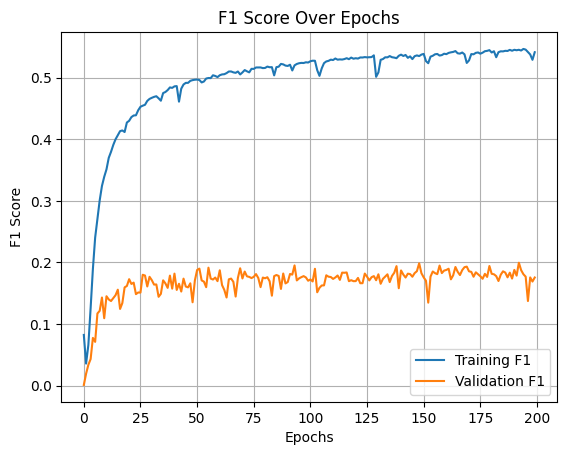

In [103]:
import matplotlib.pyplot as plt

# Assume 'history' is the object returned by model.fit()
# Replace 'f1' with the actual key you used in your model's metrics
f1_scores = history.history.get('peak_detection_metric', [])
val_f1_scores = history.history.get('val_peak_detection_metric', [])


f1_save_dir = f"{dir_start}F1_plots{dir_end}.png"

# Plot the training F1 score
plt.plot(f1_scores, label='Training F1')

plt.plot(val_f1_scores, label='Validation F1')

# Add labels, title, and legend
plt.title('F1 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(f1_save_dir, dpi=300)


# Save Model

In [104]:
lstm_model.save(f"{dir_start}models{dir_end}.h5")

#loaded_model = tf.keras.models.load_model(f"{dir_start}models{dir_end}.h5",custom_objects={'peak_detection_metric': peak_detection_metric})